In [1]:
from spectrainterface.tools import SourceFunctions
from spectrainterface.interface import SpectraInterface
from spectrainterface.sources import CPMU_PrFeB_HEPS
import numpy as np
import matplotlib.pyplot as plt

### Generate a field defined by user

[ 1968.22991164  3936.45982328  5904.68973492  7872.91964656
  9841.1495582  11809.37946984 13777.60938148 15745.83929312
 17714.06920476]


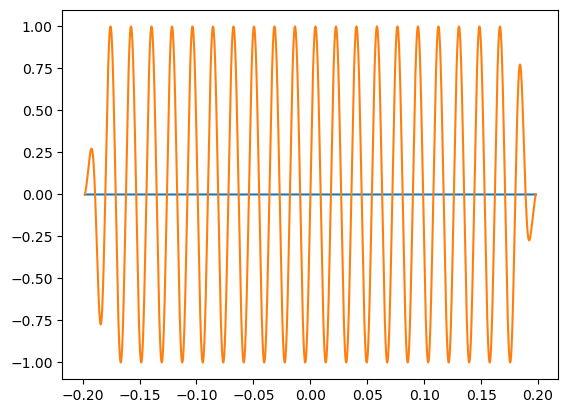

In [2]:
gamma = 3e3/0.511

sf = SourceFunctions()
period = 18
bx_peak = 0
by_peak = 1

field = sf.create_field_profile(20, period, bx_peak, by_peak, 201)

kx = sf.undulator_b_to_k(bx_peak, period)
ky = sf.undulator_b_to_k(by_peak, period)
k = np.sqrt(kx**2 + ky**2)
theta = 0.0
n = np.arange(1, 10, 1)
energy = sf.get_harmonic_energy(n, gamma, theta, period, k)
print(energy)

rz = field[:, 0]
by = field[:, 1]
bx = field[:, 2]

plt.plot(rz, bx)
plt.plot(rz, by)

#### Create an object to calc flux

In [3]:
spectra = SpectraInterface()

spectra.accelerator.set_low_beta_section()

#  Select source defined by user
spectra.calc.source_type = spectra.calc.SourceType.user_defined
spectra.calc.field = field


#### Calc flux density - spectrum

Calculation Status: 

Text(0, 0.5, 'ph/s/mm^2/0.1%B.W.')

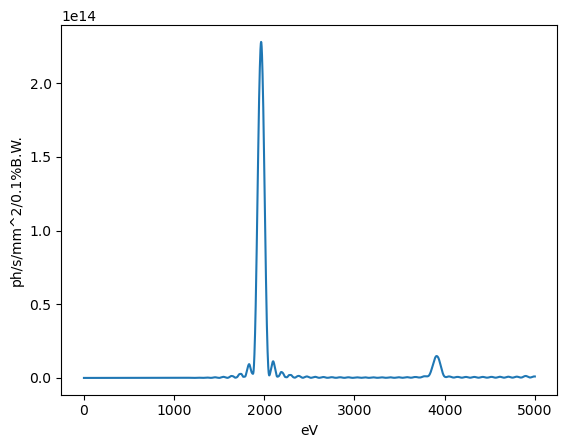

In [4]:
# Calc flux density
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.energy_range = [1, 5000]
spectra.calc.energy_step = 1
spectra.calc.observation_angle = [0, 0]

# Set configuration
spectra.calc.set_config()
spectra.calc.run_calculation()

plt.plot(spectra.calc.energies, spectra.calc.flux)
plt.xlabel(spectra.calc.output_captions['units'][0])
plt.ylabel(spectra.calc.output_captions['units'][1])

#### Calc flux slit - spectrum

Text(0, 0.5, 'ph/s/0.1%B.W.')

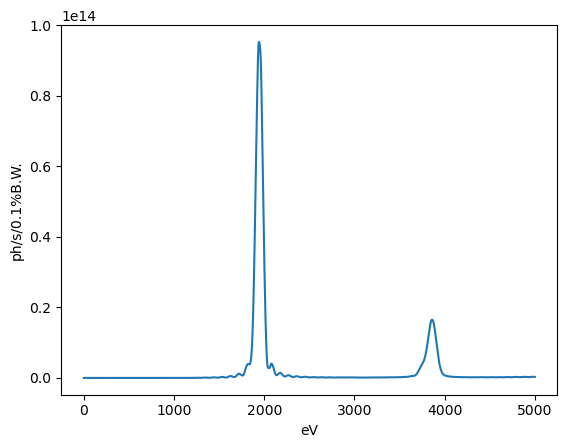

In [5]:
# Calc partial flux circular slit
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.flux
spectra.calc.slit_shape = spectra.calc.CalcConfigs.SlitShape.circular
spectra.calc.slit_acceptance = [0.0, 0.04]
spectra.calc.set_config()
spectra.calc.run_calculation()

plt.plot(spectra.calc.energies, spectra.calc.flux)
plt.xlabel(spectra.calc.output_captions['units'][0])
plt.ylabel(spectra.calc.output_captions['units'][1])


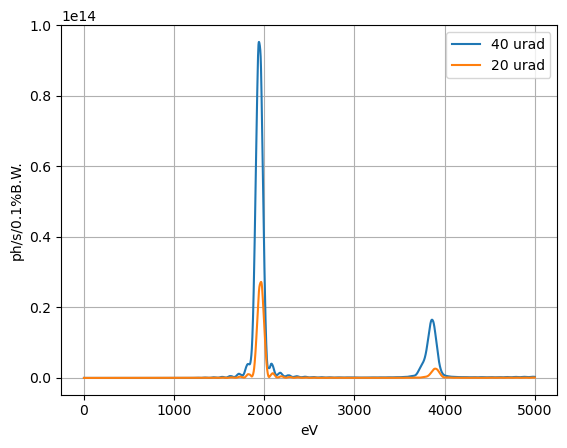

In [6]:
# Comparing flux for two different slits
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.flux
spectra.calc.slit_shape = spectra.calc.CalcConfigs.SlitShape.circular

spectra.calc.slit_acceptance = [0.0, 0.04]
spectra.calc.set_config()
spectra.calc.run_calculation()
energies = spectra.calc.energies
flux0 = spectra.calc.flux

spectra.calc.slit_acceptance = [0.0, 0.02]
spectra.calc.set_config()
spectra.calc.run_calculation()
flux1 = spectra.calc.flux

plt.plot(energies, flux0, label='40 urad')
plt.plot(energies, flux1, label='20 urad')
plt.xlabel(spectra.calc.output_captions['units'][0])
plt.ylabel(spectra.calc.output_captions['units'][1])
plt.legend()
plt.grid()

#### Calc spatial distribution of flux

In [7]:
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.flux_density
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.target_energy = 5850
spectra.calc.x_range = [-0.05, 0.05]
spectra.calc.y_range = [-0.05, 0.05]
spectra.calc.x_nr_pts = 51
spectra.calc.y_nr_pts = 51
spectra.calc.set_config()
spectra.calc.run_calculation()


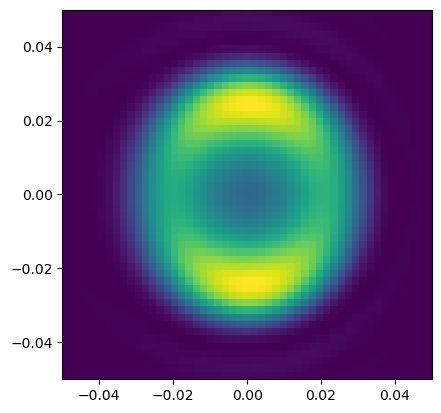

In [8]:
# Example of detuned beam
x = spectra.calc.x
y = spectra.calc.y

flux = spectra.calc.flux
plt.imshow(flux, extent=[x[0], x[-1], y[0], y[-1]])

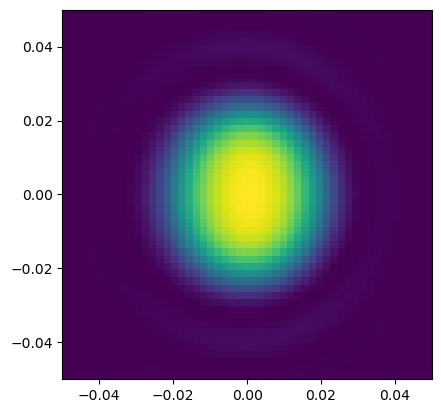

In [9]:
# Example of ressonant beam
spectra.calc.target_energy = 5904
spectra.calc.set_config()
spectra.calc.run_calculation()
flux2 = spectra.calc.flux
plt.imshow(flux2, extent=[x[0], x[-1], y[0], y[-1]])

In [ ]:
# Obtaining spectrum using spatial flux distribution
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.flux_density
spectra.calc.x_range = [-0.02, 0.02]
spectra.calc.y_range = [-0.02, 0.02]
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
energies = np.linspace(5700, 6000, 20)
flux = np.zeros(len(energies))
for i, energy in enumerate(energies):
    print(energy)
    spectra.calc.target_energy = energy
    spectra.calc.set_config()
    spectra.calc.run_calculation()
    x = spectra.calc.x
    y = spectra.calc.y
    flux_density = spectra.calc.flux
    flux_density = np.reshape(flux_density, (len(x), len(y)))
    flux[i] = np.sum(flux_density)


In [ ]:
plt.plot(energies, flux)
plt.ylabel("Flux")
plt.xlabel("Energy [eV]")

### Calc flux of a pre configured undulator

In [2]:
period = 18
by_peak = 1
bx_peak = 1
id_length = 2
gamma = 3e3/0.511

spectra = SpectraInterface()

spectra.accelerator.set_low_beta_section()

#  Select horizontal undulator as source
spectra.calc.source_type = (
    spectra.calc.SourceType.horizontal_undulator
)

spectra.calc.period = period
spectra.calc.by_peak = by_peak
# spectra.calc.bx_peak = bx_peak
spectra.calc.length = id_length

In [3]:
sf = SourceFunctions()
ky = spectra.calc.ky
kx = spectra.calc.kx
kx = 0
k = np.sqrt(kx**2 + ky**2)
n = np.arange(1, 10, 1)
energy = sf.get_harmonic_energy(n, gamma, 0, period, k)
print(energy)


[ 1968.22991164  3936.45982328  5904.68973492  7872.91964656
  9841.1495582  11809.37946984 13777.60938148 15745.83929312
 17714.06920476]


#### Flux density

Calculation Status: 

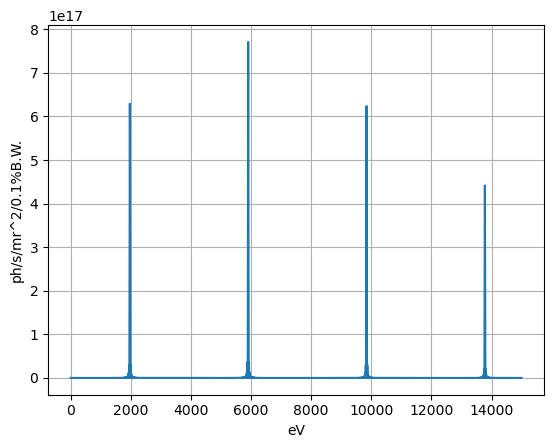

In [4]:
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.distance_from_source = 1
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.observation_angle = [0, 0]
spectra.calc.energy_range = [1, 15000]
spectra.calc.energy_step = 1
spectra.calc.set_config()
spectra.calc.run_calculation()

plt.plot(
    spectra.calc.energies,
    spectra.calc.flux,
)
plt.xlabel(spectra.calc.output_captions["units"][0])
plt.ylabel(spectra.calc.output_captions["units"][1])
plt.grid()

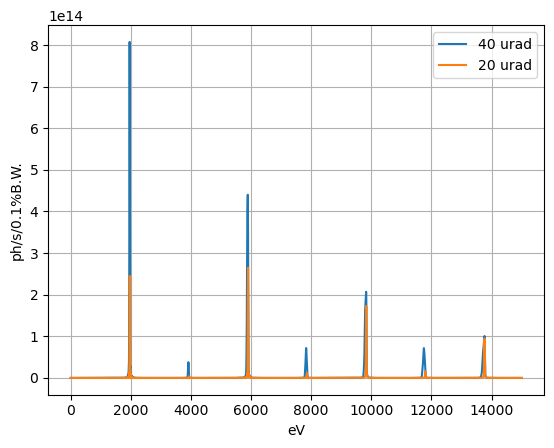

In [5]:
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux
)
spectra.calc.distance_from_source = 1
spectra.calc.slit_shape = spectra.calc.CalcConfigs.SlitShape.rectangular
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.observation_angle = [0, 0]
spectra.calc.slit_acceptance = [-0.04, 0.04]
spectra.calc.energy_range = [1, 15000]
spectra.calc.energy_step = 1
spectra.calc.set_config()
spectra.calc.run_calculation()
flux0 = spectra.calc.flux

spectra.calc.slit_acceptance = [-0.02, 0.02]
spectra.calc.set_config()
spectra.calc.run_calculation()
flux1 = spectra.calc.flux


plt.plot(spectra.calc.energies, flux0, label='40 urad')
plt.plot(spectra.calc.energies, flux1, label='20 urad')
plt.xlabel(spectra.calc.output_captions['units'][0])
plt.ylabel(spectra.calc.output_captions['units'][1])
plt.legend()
plt.grid()

In [6]:
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.distance_from_source = 1
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.target_energy = 1968.22991164
spectra.calc.x_range = [-0.02, 0.02]
spectra.calc.y_range = [-0.02, 0.02]
spectra.calc.x_nr_pts = 201
spectra.calc.y_nr_pts = 201
spectra.calc.set_config()
spectra.calc.run_calculation()

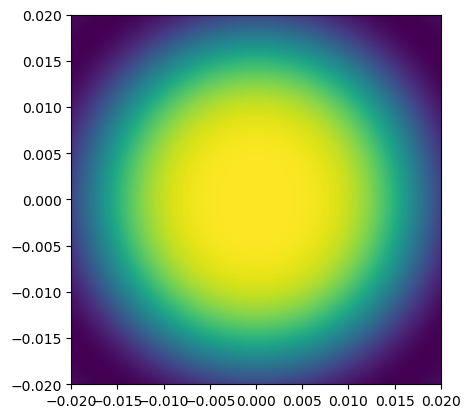

In [7]:
x = spectra.calc.x
y = spectra.calc.y

flux = spectra.calc.flux
plt.imshow(flux, extent=[x[0], x[-1], y[0], y[-1]])

#### Power density

In [8]:
spectra.calc.method = spectra.calc.CalcConfigs.Method.near_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.power_density
)
spectra.calc.distance_from_source = 50
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.x_range = [-1.0, 1.0]
spectra.calc.y_range = [-1.0, 1.0]
spectra.calc.x_nr_pts = 201
spectra.calc.y_nr_pts = 201
spectra.calc.set_config()
spectra.calc.run_calculation()

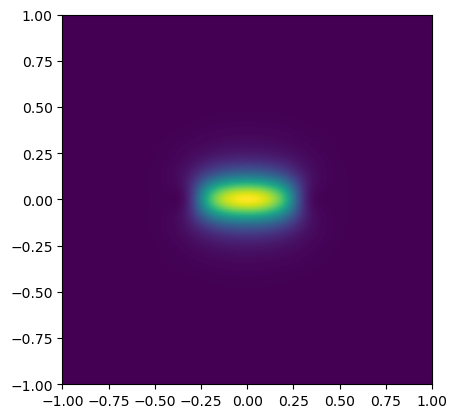

In [9]:
x = spectra.calc.x
y = spectra.calc.y

power = spectra.calc.power_density
plt.imshow(power, extent=[x[0], x[-1], y[0], y[-1]])

### Calc brilliance  undulator

In [10]:
period = 20
by_peak = 0.25
id_length = 0.4
gamma = 3e3/0.511

spectra = SpectraInterface()

spectra.accelerator.set_low_beta_section()

#  Select horizontal undulator as source
spectra.calc.source_type = (
    spectra.calc.SourceType.horizontal_undulator
)

spectra.calc.period = period
spectra.calc.by_peak = by_peak
spectra.calc.length = id_length

In [11]:
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.brilliance
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.k
spectra.calc.method = spectra.calc.CalcConfigs.Method.wigner
spectra.calc.harmonic_range = [1, 5]
spectra.calc.k_range = [0, 3]
spectra.calc.k_nr_pts = 21
spectra.calc.slice_x = 0
spectra.calc.slice_px = 0
spectra.calc.slice_y = 0
spectra.calc.slice_py = 0

In [12]:
spectra.calc.set_config()
spectra.calc.run_calculation()

In [13]:
energies, brilliance = spectra.calc.process_brilliance_curve(
    spectra.calc.energies, spectra.calc.brilliance
)

/home/gabriel/repos/spectrainterface/spectrainterface/interface.py:1573: RuntimeWarning: divide by zero encountered in log
  _np.interp(e_harm_interp, e_harm, _np.log(b_harm))
/home/gabriel/repos/spectrainterface/spectrainterface/interface.py:1590: RuntimeWarning: divide by zero encountered in log
  e_next_harm_interp, e_next_harm, _np.log(b_next_harm)


In [14]:

e1, b1 = energies[0, :], brilliance[0, :]
e3, b3 = energies[1, :], brilliance[1, :]
e5, b5 = energies[2, :], brilliance[2, :]


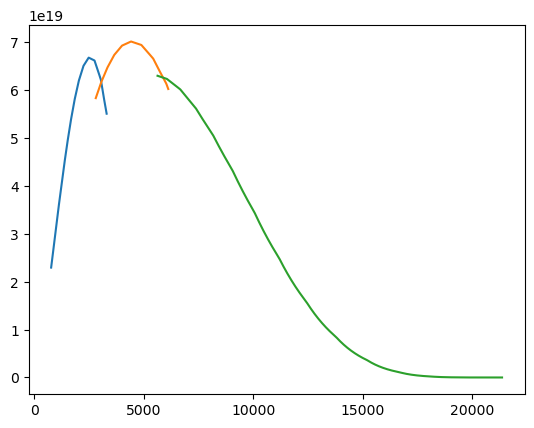

In [15]:
plt.plot(e1, b1, color='C0')
plt.plot(e3, b3, color='C1')
plt.plot(e5, b5, color='C2')

### Calc brilliance BM

In [23]:
period = 18
by_peak = 0.25
length = 1
gamma = 3e3/0.511

spectra = SpectraInterface()
spectra.accelerator.set_low_beta_section()

spectra.calc.source_type = spectra.calc.SourceType.bending_magnet
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.slit_acceptance = 2
spectra.calc.by_peak = by_peak
spectra.calc.length = length
spectra.calc.distance_from_source = 20
spectra.accelerator.zero_emittance = False
spectra.accelerator.zero_energy_spread = False
spectra.calc.observation_angle = [0, 0]
spectra.calc.energy_range = [1, 50000]
spectra.calc.energy_step = 20
spectra.calc.set_config()
spectra.calc.run_calculation()

In [20]:
period = 18
by_peak = 0.25
length = 1
gamma = 3e3/0.511

spectra = SpectraInterface()
spectra.accelerator.set_low_beta_section()

spectra.calc.source_type = spectra.calc.SourceType.bending_magnet
spectra.calc.method = spectra.calc.CalcConfigs.Method.near_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.slit_acceptance = 2
spectra.calc.by_peak = by_peak
spectra.calc.length = length
spectra.calc.distance_from_source = 20
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
spectra.calc.x_range = [-0.1, 0.1]
spectra.calc.y_range = [-0.1, 0.1]
spectra.calc.x_nr_pts = 101
spectra.calc.y_nr_pts = 101
spectra.calc.target_energy = 14525
spectra.calc.set_config()
spectra.calc.run_calculation()

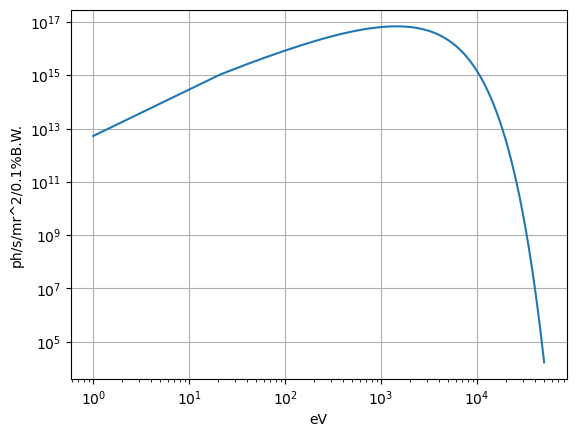

In [24]:
plt.yscale('log')
plt.xscale('log')
plt.plot(
    spectra.calc.energies,
    spectra.calc.brilliance,
)
plt.xlabel(spectra.calc.output_captions["units"][0])
plt.ylabel(spectra.calc.output_captions["units"][1])
plt.grid()

### Calc brilliance wiggler

In [29]:
period = 180
by_peak = 0.25
length = 1
gamma = 3e3/0.511

spectra = SpectraInterface()
spectra.accelerator.set_low_beta_section()

spectra.calc.source_type = spectra.calc.SourceType.wiggler
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.energy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.period = period
spectra.calc.by_peak = by_peak
spectra.calc.length = length
spectra.calc.distance_from_source = 20
spectra.accelerator.zero_emittance = False
spectra.accelerator.zero_energy_spread = False
spectra.calc.observation_angle = [0, 0]
spectra.calc.energy_range = [1, 50000]
spectra.calc.energy_step = 20
spectra.calc.set_config()
spectra.calc.run_calculation()

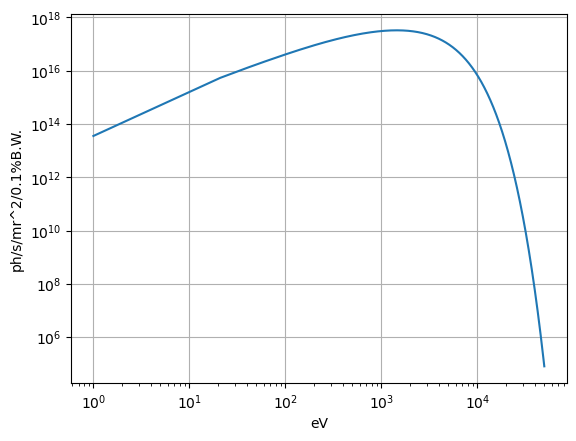

In [30]:
plt.yscale('log')
plt.xscale('log')
plt.plot(
    spectra.calc.energies,
    spectra.calc.brilliance,
)
plt.xlabel(spectra.calc.output_captions["units"][0])
plt.ylabel(spectra.calc.output_captions["units"][1])
plt.grid()

In [26]:
period = 180
by_peak = 0.25
length = 1
gamma = 3e3/0.511

spectra = SpectraInterface()
spectra.accelerator.set_low_beta_section()

spectra.calc.source_type = spectra.calc.SourceType.wiggler
spectra.calc.method = spectra.calc.CalcConfigs.Method.far_field
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_xy
spectra.calc.output_type = (
    spectra.calc.CalcConfigs.Output.flux_density
)
spectra.calc.period = period
spectra.calc.by_peak = by_peak
spectra.calc.length = length
spectra.calc.distance_from_source = 20
spectra.accelerator.zero_emittance = True
spectra.accelerator.zero_energy_spread = True
# spectra.calc.observation_angle = [0, 0]
# spectra.calc.energy_range = [1, 50000]
# spectra.calc.energy_step = 20
spectra.calc.x_range = [-0.1, 0.1]
spectra.calc.y_range = [-0.1, 0.1]
spectra.calc.x_nr_pts = 201
spectra.calc.y_nr_pts = 201
spectra.calc.target_energy = 1000
spectra.calc.set_config()
spectra.calc.run_calculation()

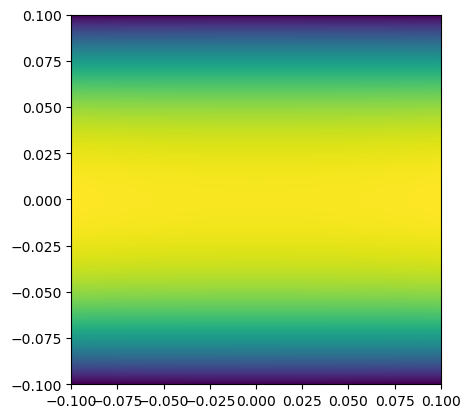

In [27]:
x = spectra.calc.x
y = spectra.calc.y

power = spectra.calc.flux
plt.imshow(power, extent=[x[0], x[-1], y[0], y[-1]])

### Loops

In [6]:
from spectrainterface.sources import Planar, Delta, Hybrid, Wiggler, B2, BC

planar = Planar(25, 1.2)
delta = Delta(40, 1.0)
hybrid = Hybrid(18, 1.5)
wig = Wiggler(180, 1)
b2 = B2()
bc = BC()

spectra = SpectraInterface()
spectra.accelerator.set_bsc_with_ivu18()
spectra.accelerator.set_low_beta_section()

spectra.sources = [planar, delta, b2]
betas = ['low', 'low', 'b2']

spectra.calc_brilliance_curve([1, 15], 13, emax=50000, beta_sections=betas)

Calculating curve for source 1/3
Calculating curve for source 2/3
Calculating curve for source 3/3


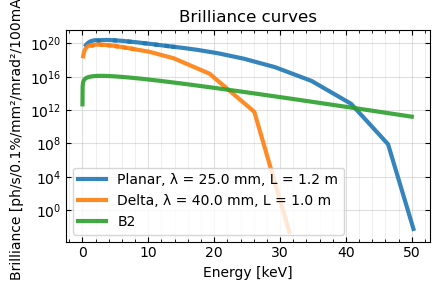

In [7]:
spectra.plot_brilliance_curve(process_curves=True, superp_value=20)

In [10]:
from spectrainterface.sources import Planar, Delta, Hybrid, Wiggler, B2, BC

planar = Planar(25, 1.2)
delta = Delta(40, 1.0)
delta.polarization = 'hp'
delta.fields_ratio = 1


spectra = SpectraInterface()
spectra.accelerator.set_bsc_with_ivu18()
spectra.accelerator.set_low_beta_section()
planar.add_phase_errors = True

spectra.sources = [planar, delta]
betas = ["low", "low"]

spectra.calc_flux_curve(
    energy_range=[1, 20000],
    harmonic_range=[1, 30],
    nr_pts_k=51,
    kmin=0.2,
    slit_shape="circslit",
    slit_acceptances=[[0.0, 0.01], [0.0, 0.08]],
    beta_sections=betas,
)

Calculating curve for source 1/2
Calculating curve for source 2/2


In [11]:
%matplotlib qt5
spectra.plot_flux_curve(process_curves=True, superp_value=20)

## PhaseSpace

In [4]:
spectra = SpectraInterface()
spectra.accelerator.set_bsc_orion_reduction()
spectra.accelerator.set_high_beta_section()

In [5]:
source = CPMU_PrFeB_HEPS(14, 2.05)
source.vc_tolerance = 0.20
source.polarization = "hp"
source.add_phase_errors = True
source.use_recovery_params = True

In [6]:
gapv, gaph = source.calc_min_gap(spectra.accelerator)
kmax = source.calc_max_k(spectra.accelerator)

print(
    "Period: {:.2f} mm | Length: {:.2f} m".format(
        source.period, source.source_length
    )
)
if source.polarization == "cp":
    print("Min. gapv: {:.4f} mm | Min gaph: {:.3f} mm".format(gapv, gaph))
elif source.polarization == "hp":
    print("Min. gapv: {:.4f} mm".format(gapv))
else:
    print("Min. gaph: {:.3f} mm".format(gaph))
print(
    "Máx. k: {:.4f} | Máx. B: {:.2f} T".format(
        kmax, source.undulator_k_to_b(kmax, source.period)
    )
)

Period: 14.00 mm | Length: 2.05 m
Min. gapv: 4.9328 mm
Máx. k: 1.3865 | Máx. B: 1.06 T


In [9]:
spectra.calc.source_type = source.source_type
spectra.calc.method = spectra.calc.CalcConfigs.Method.wigner
spectra.calc.indep_var = spectra.calc.CalcConfigs.Variable.mesh_yyp
spectra.calc.output_type = spectra.calc.CalcConfigs.Output.phasespace

spectra.calc.period = source.period
spectra.calc.length = source.source_length

spectra.calc.ky = kmax
spectra.calc.target_harmonic = 3
spectra.calc.y_range = [-0.02, 0.02]
spectra.calc.yp_range = [-0.02, 0.02]
spectra.calc.y_nr_pts = 101
spectra.calc.yp_nr_pts = 101

spectra.calc.set_config()
spectra.calc.run_calculation()

brilliance = spectra.calc.output_data
brilliance = brilliance.reshape(spectra.calc.yp_nr_pts, spectra.calc.y_nr_pts)

<function matplotlib.pyplot.show(close=None, block=None)>

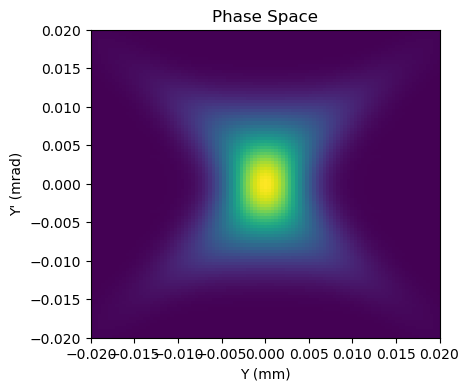

In [10]:
plt.figure(figsize=(4.5, 4))

plt.title("Phase Space")
plt.imshow(
    brilliance,
    extent=[*spectra.calc.y_range, *spectra.calc.yp_range],
    aspect="auto",
)
plt.xlabel("Y (mm)")
plt.ylabel("Y' (mrad)")
plt.show